In [1]:
import torch

from torch import nn
from torch.nn import functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
device = (
    "cuda"  # nvidia GPU
    if torch.cuda.is_available()
    else "mps"  # mac GPU
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Prepare dataset

In [3]:
train_df = pd.read_csv("data/train/train.csv")
train_df.head(5)

,filename,building,camera,height
0,photo_1_2024-02-28_19-50-55.jpg,"55.83374598606761, 37.4863818073886","55.83355618950865, 37.48563078891009",24
1,photo_2_2024-02-28_19-50-55.jpg,"55.74671515046505, 37.49455264385141","55.74689329318663, 37.49520710283597",21
2,photo_3_2024-02-28_19-50-55.jpg,"55.759007045864244, 37.71650413890229","55.758900299637965, 37.71613626315986",18
3,photo_4_2024-02-28_19-50-55.jpg,"55.781247169148855, 37.540942963066165","55.78183117969778, 37.54023985374589",18
4,photo_5_2024-02-28_19-50-55.jpg,"55.63435687287336, 37.765668872386286","55.63416610435083, 37.76433849674555",51


In [4]:
class CoordinatesTransformPipeline:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        
    @staticmethod
    def distance(x: np.ndarray, y: np.ndarray) -> float:
        """
        Great-circle distance: https://en.wikipedia.org/wiki/Great-circle_distance
        Returns distance between x and y in meters
        """
        x, y = np.radians(x), np.radians(y)
        r = 6_371_000  # meters
        delta_lambda = np.abs(x[1] - y[1])
        return np.arccos(np.sin(x[0]) * np.sin(y[0]) + 
                         np.cos(x[0]) * np.cos(y[0]) * 
                         np.cos(delta_lambda)) * r
    
    def transform(self) -> pd.DataFrame:
        coords_columns = ["building", "camera"]

        for col in coords_columns:
            self.df[col] = self.coords_transform(self.df[col])

        dists = []
        for i in range(len(self.df)):
            dists.append(self.distance(
                self.df[coords_columns[0]].iloc[i],
                self.df[coords_columns[1]].iloc[i]
            ))
        self.df["distance"] = pd.Series(dists)
        return self.df.drop(columns=coords_columns)[["filename", "distance", "height"]]
            
    
    def coords_transform(self, column: pd.Series) -> pd.Series:
        splited = column.str.split(",")
        result = []
        for i in range(len(self.df)):
            result.append(np.array(
                splited.iloc[i], 
                dtype=np.float64)
            )
        return pd.Series(result)

In [5]:
transformer = CoordinatesTransformPipeline(train_df)
train_df = transformer.transform()
train_df.head(5)

,filename,distance,height
0,photo_1_2024-02-28_19-50-55.jpg,51.428476,24
1,photo_2_2024-02-28_19-50-55.jpg,45.498280,21
2,photo_3_2024-02-28_19-50-55.jpg,25.896985,18
3,photo_4_2024-02-28_19-50-55.jpg,78.422418,18
4,photo_5_2024-02-28_19-50-55.jpg,86.155339,51


In [6]:
class BuildingDataset(torch.utils.data.Dataset):
    """
    Torch dataset
    
    Returns tuple of form: tensor_image, tensor_dist, tensor_y
    (resize image to 400x400 pixels)
    
    - tensor_image is image of shape (n_channels, height, width),
    - tensor_dist is distance between camera and building in meters,
    - tensor_y is target.
    """
    normalize_params = {
        "mean": None,
        "std": None
    }
    
    def __init__(self, folder: str, df: pd.DataFrame):
        self.df = df
        self.df[["distance", "height"]] = self.numerical_normalize(self.df[["distance", "height"]])
        self.folder = folder
        
    def __len__(self) -> int:
        return len(self.df)
    
    @staticmethod
    def image2tensor(pic: Image, device: str = None) -> torch.Tensor:
        img = torch.as_tensor(np.array(pic, copy=True), device=device, dtype=torch.float32)
        img = img.view(pic.size[1], pic.size[0], 3)
        # put it from HWC to CHW format
        img = img.permute((2, 0, 1))
        return img

    def numerical_normalize(self, data: pd.DataFrame | float | int) -> pd.DataFrame | float:
        """
        Returns normalized data.
        """
        if self.normalize_params["mean"] is None and self.normalize_params["std"] is None:
            self.normalize_params["mean"] = data.mean()
            self.normalize_params["std"] = data.std()

        data = (data - self.normalize_params["mean"]) / self.normalize_params["std"]
        return data

    def __getitem__(self, key: int) -> tuple[torch.Tensor,
                                             torch.Tensor,
                                             torch.Tensor]:
        filename = f"{self.folder}/{self.df['filename'].iloc[key]}"
        
        return (self.image2tensor(Image.open(filename), device=device)[:,:-200,150:-370],
                torch.tensor(self.df["distance"].iloc[key], device=device, dtype=torch.float32),
                torch.tensor(self.df["height"].iloc[key], device=device, dtype=torch.float32))

torch.Size([3, 400, 400]) torch.Size([]) torch.Size([])


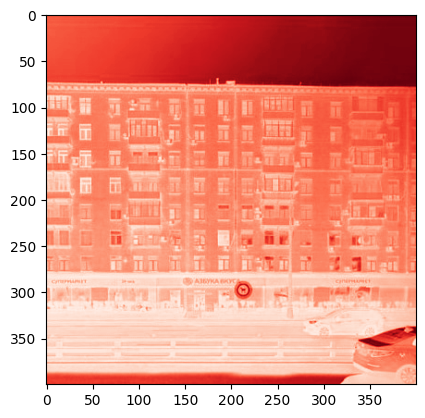

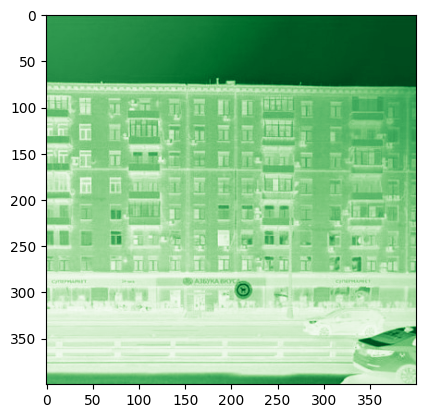

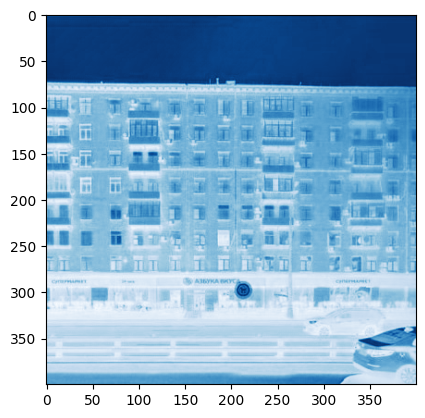

tensor(-0.3171, device='mps:0') tensor(-0.0662, device='mps:0')


In [7]:
dataset = BuildingDataset("data/train", train_df)
for image, x, y in dataset:
    print(image.shape, x.shape, y.shape)
    for channel, cm in zip(image, ["Reds", "Greens", "Blues"]):
        plt.imshow(channel.to("cpu"), cmap=cm)
        plt.show()
    print(x, y)
    break

In [8]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, pin_memory=True)

# test batches
for i, (image, x, y) in enumerate(dataloader):
    print(f"Batch num: {i}, input: {image.shape}, {x.shape}, {y.shape}, devices: {image.device}, {x.device}, {y.device}", end="\n\n")

Batch num: 0, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 1, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 2, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 3, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 4, input: torch.Size([4, 3, 400, 400]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0



# Develop NN architecture

## Loss

In [9]:
loss = nn.MSELoss()
lr = 1e-3
epochs = 15

## Train, Test loops

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader)
    losses = []
    
    model.train()
    for batch, (image, dist, y) in enumerate(dataloader):
        pred = model((image, dist))
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.item())
        print(f"loss: {loss:>7f}  [{batch + 1}/{size}]")
    losses = np.array(losses)

    plt.plot(np.arange(1, len(dataloader) + 1), losses, color="red")
    plt.grid()
    plt.xlabel("Batch")
    plt.ylabel("MSE")
    plt.title("Train loss")
    plt.show()


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    losses = []

    with torch.no_grad():
        for image, dist, y in dataloader:
            pred = model((image, dist))
            losses.append(loss_fn(pred, y).item())
    losses = np.array(losses)
    
    plt.plot(np.arange(1, len(dataloader) + 1), losses)
    plt.grid()
    plt.xlabel("Batch")
    plt.ylabel("MSE")
    plt.title("Test loss")
    plt.show()

    print(f"Avg test loss: {losses.mean():>8f} \n")

## AlexNet

Epoch 1
-------------------------------


/Users/danila/Documents/Python Projects/Competition/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 1.640562  [1/5]
loss: 25334.423828  [2/5]
loss: 0.305631  [3/5]
loss: 0.519760  [4/5]
loss: 11.207703  [5/5]


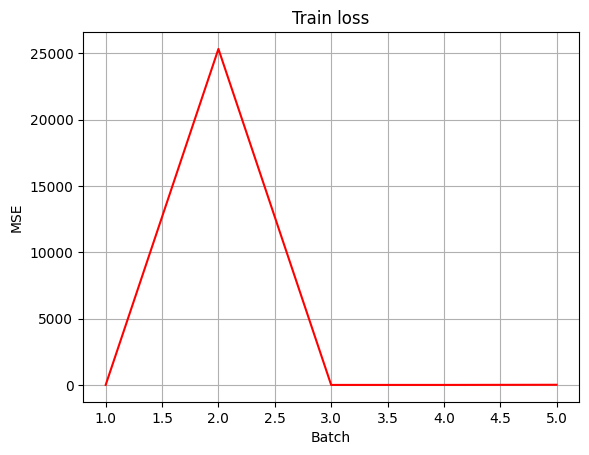

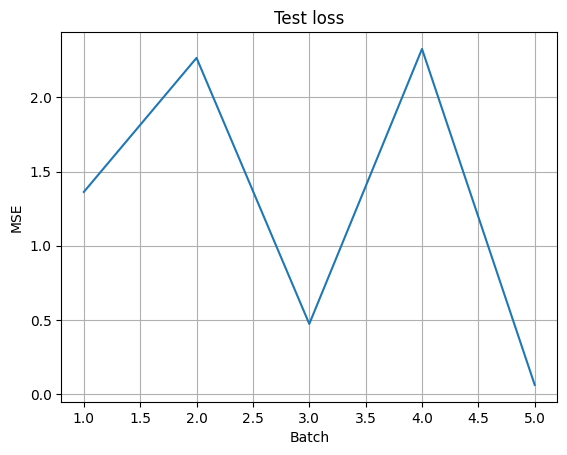

Avg test loss: 1.297624 

Epoch 2
-------------------------------
loss: 1.421151  [1/5]
loss: 1.876881  [2/5]
loss: 0.661557  [3/5]
loss: 0.167694  [4/5]
loss: 1.648665  [5/5]


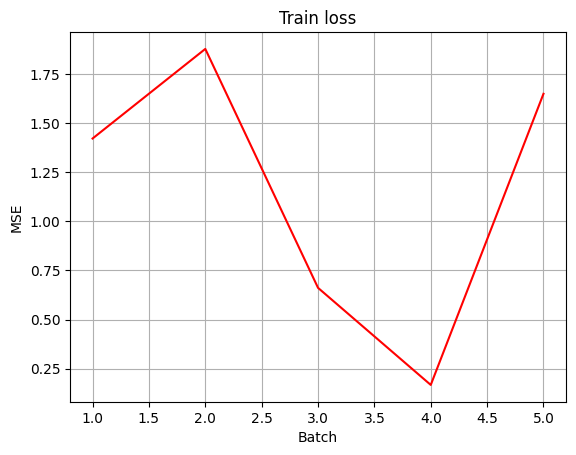

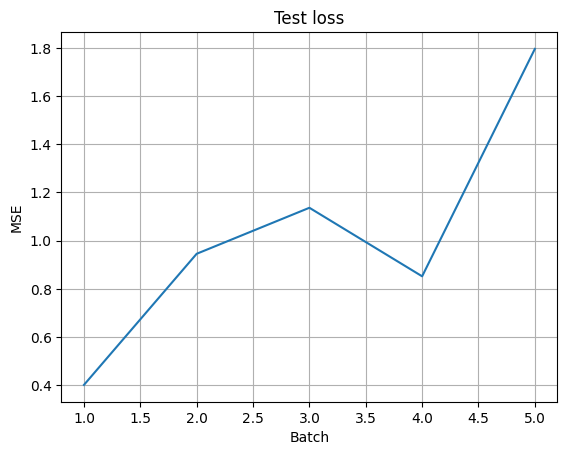

Avg test loss: 1.026464 

Epoch 3
-------------------------------
loss: 0.996761  [1/5]
loss: 0.325791  [2/5]
loss: 1.957545  [3/5]
loss: 2.327595  [4/5]
loss: 0.617419  [5/5]


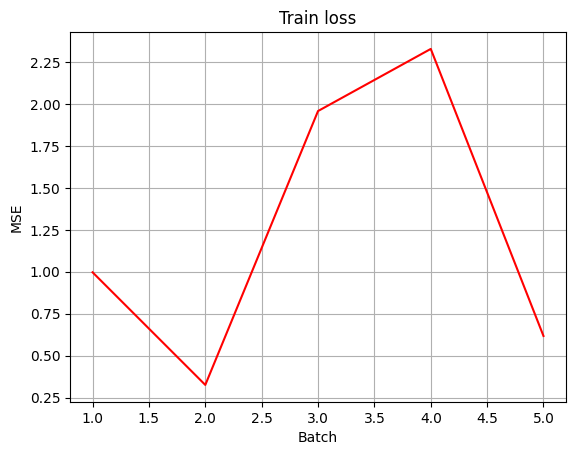

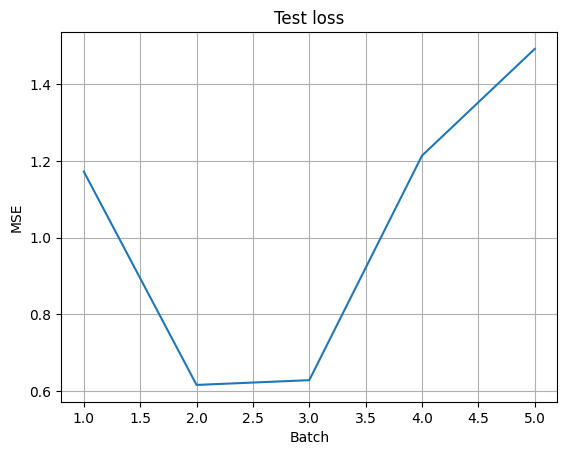

Avg test loss: 1.024375 

Epoch 4
-------------------------------
loss: 1.355518  [1/5]
loss: 0.980821  [2/5]
loss: 1.403003  [3/5]
loss: 1.051955  [4/5]
loss: 0.667711  [5/5]


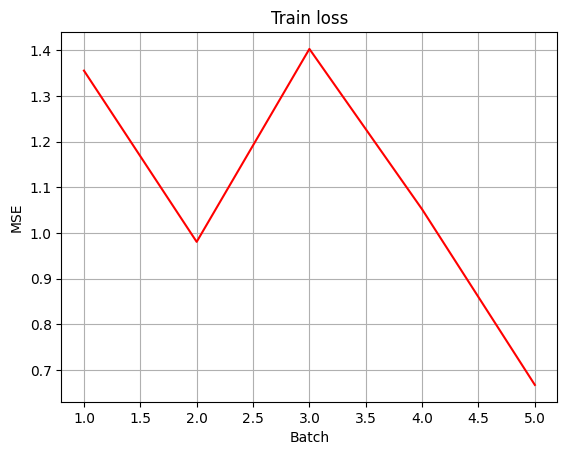

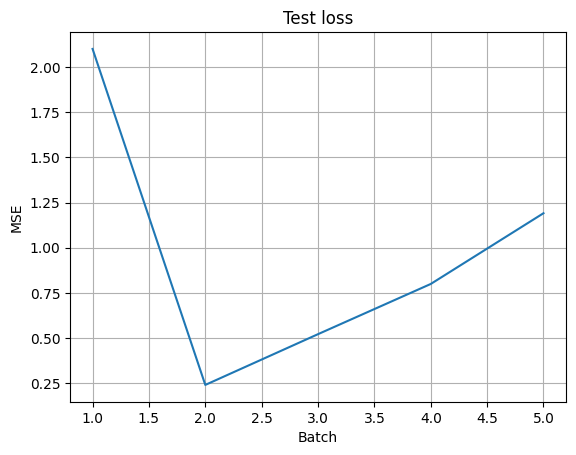

Avg test loss: 0.970688 

Epoch 5
-------------------------------
loss: 0.428982  [1/5]
loss: 0.753847  [2/5]
loss: 11.609468  [3/5]
loss: 1.106643  [4/5]
loss: 0.538666  [5/5]


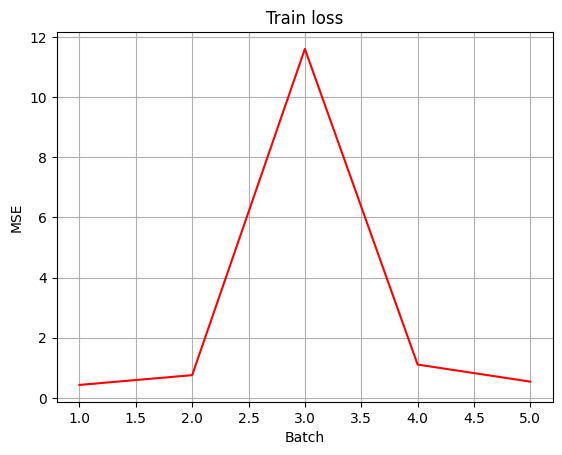

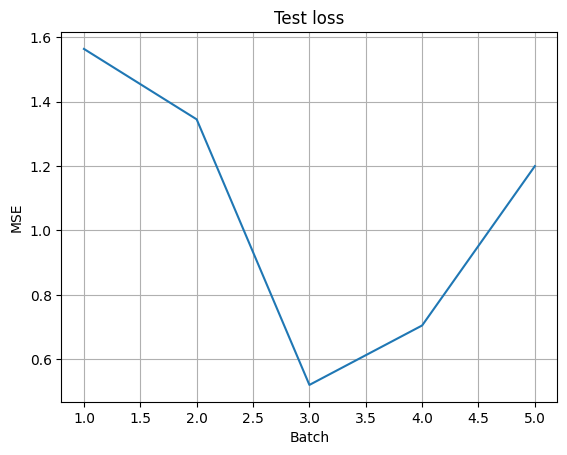

Avg test loss: 1.066754 

Epoch 6
-------------------------------
loss: 0.690869  [1/5]
loss: 0.582459  [2/5]
loss: 1.937466  [3/5]
loss: 1.111282  [4/5]
loss: 1.161055  [5/5]


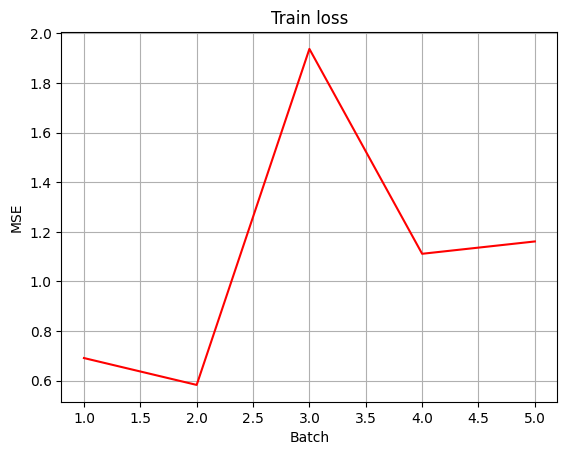

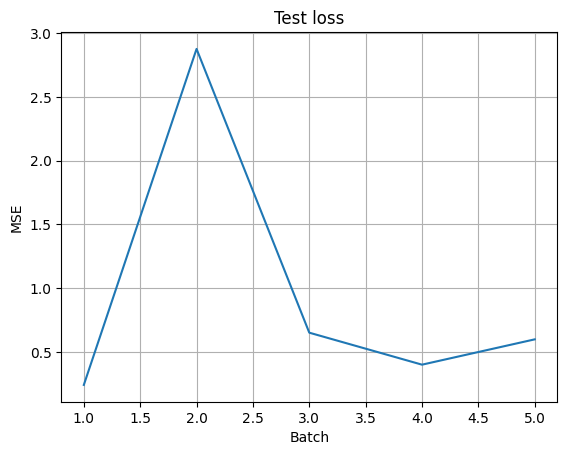

Avg test loss: 0.953902 

Epoch 7
-------------------------------
loss: 1.565323  [1/5]
loss: 1.252045  [2/5]
loss: 1.357861  [3/5]
loss: 0.281527  [4/5]
loss: 0.320050  [5/5]


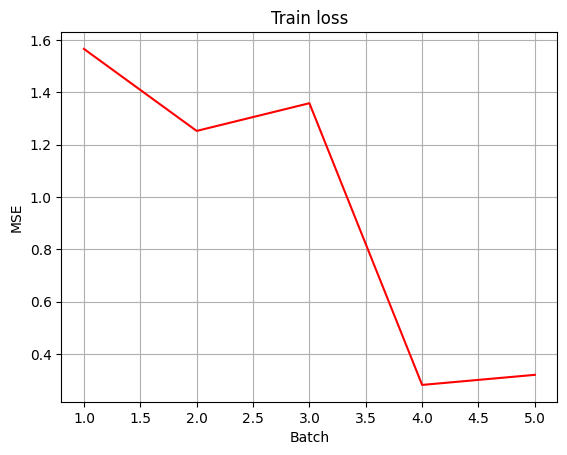

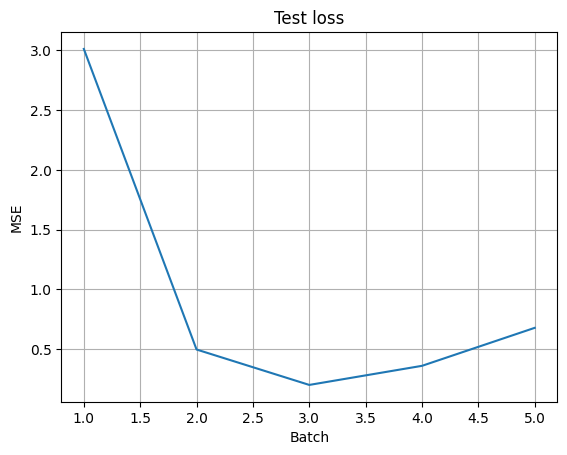

Avg test loss: 0.950362 

Epoch 8
-------------------------------
loss: 1.351683  [1/5]
loss: 0.467179  [2/5]
loss: 1.543912  [3/5]
loss: 0.645816  [4/5]
loss: 0.745236  [5/5]


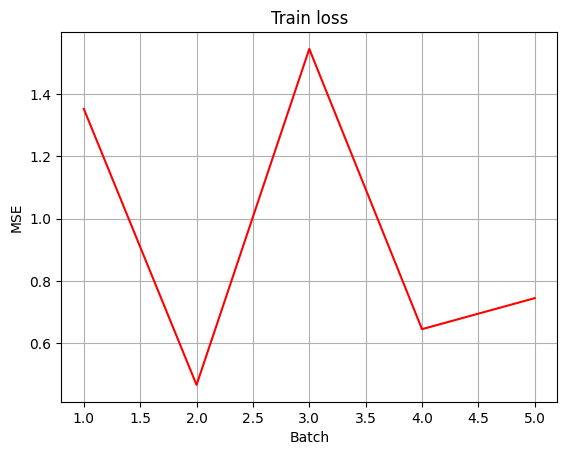

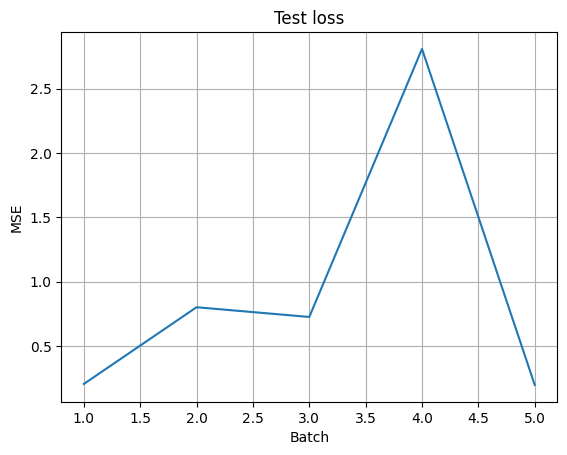

Avg test loss: 0.946357 

Epoch 9
-------------------------------
loss: 1.617571  [1/5]
loss: 1.047981  [2/5]
loss: 0.284194  [3/5]
loss: 1.519938  [4/5]
loss: 0.271949  [5/5]


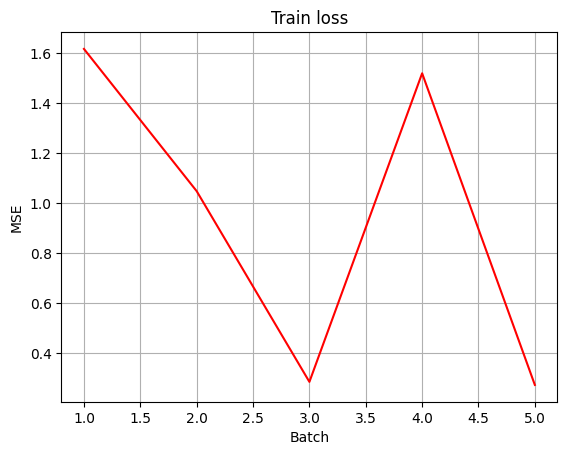

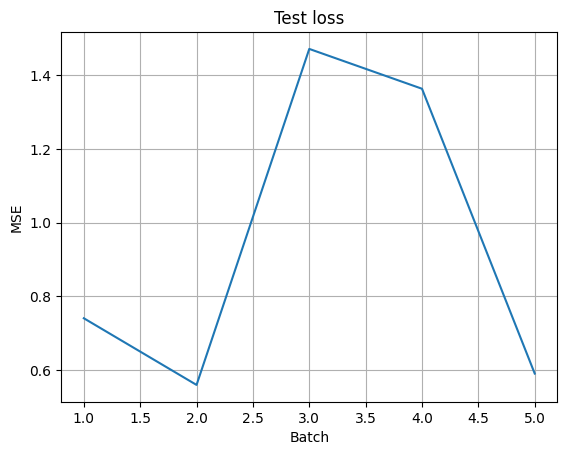

Avg test loss: 0.944954 

Epoch 10
-------------------------------
loss: 0.613925  [1/5]
loss: 0.306074  [2/5]
loss: 0.840780  [3/5]
loss: 0.675217  [4/5]
loss: 2.254342  [5/5]


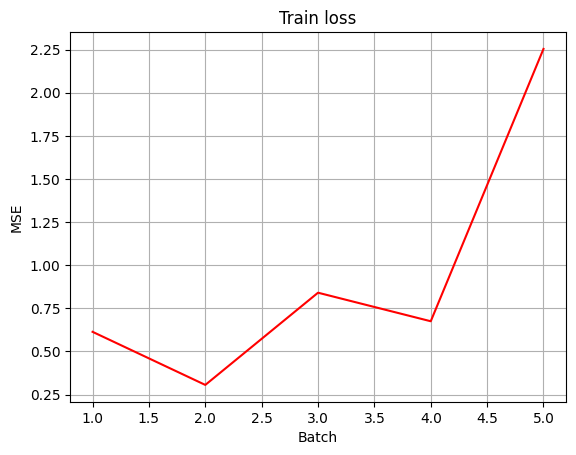

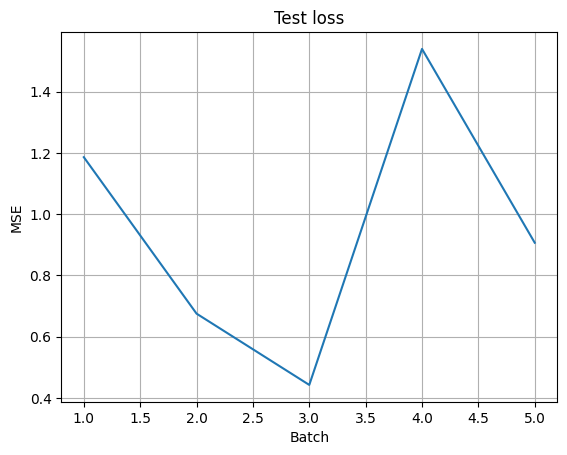

Avg test loss: 0.949899 

Epoch 11
-------------------------------
loss: 0.769253  [1/5]
loss: 0.875348  [2/5]
loss: 2.245596  [3/5]
loss: 0.229636  [4/5]
loss: 0.601066  [5/5]


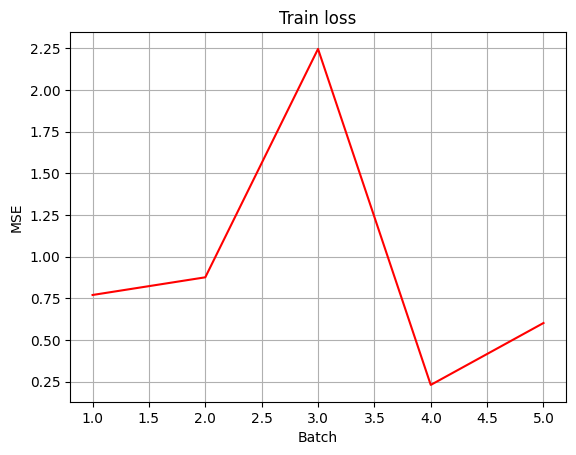

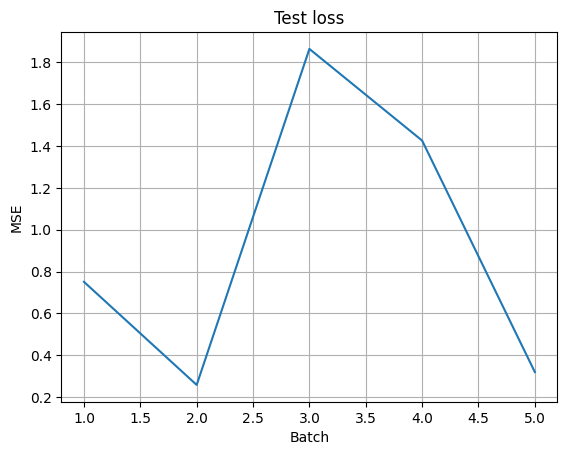

Avg test loss: 0.923799 

Epoch 12
-------------------------------
loss: 0.193175  [1/5]
loss: 0.540387  [2/5]
loss: 0.189776  [3/5]
loss: 3.026263  [4/5]
loss: 0.746719  [5/5]


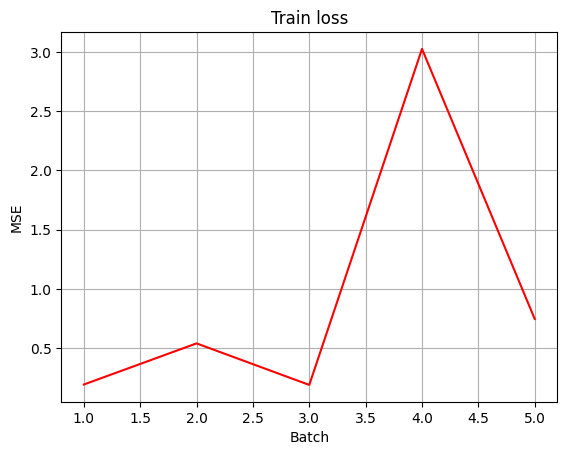

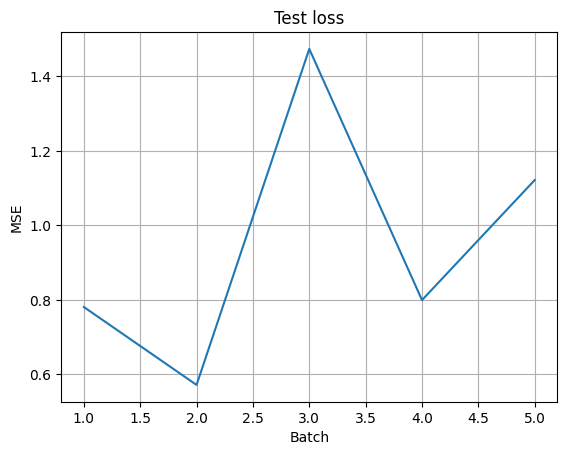

Avg test loss: 0.949402 

Epoch 13
-------------------------------
loss: 0.893992  [1/5]
loss: 0.142736  [2/5]
loss: 0.156370  [3/5]
loss: 1.830200  [4/5]
loss: 1.598459  [5/5]


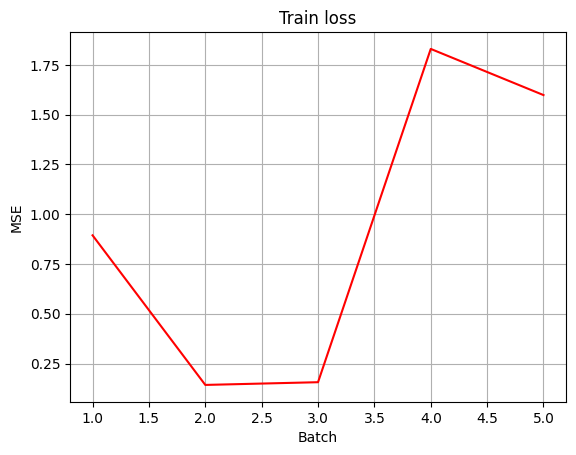

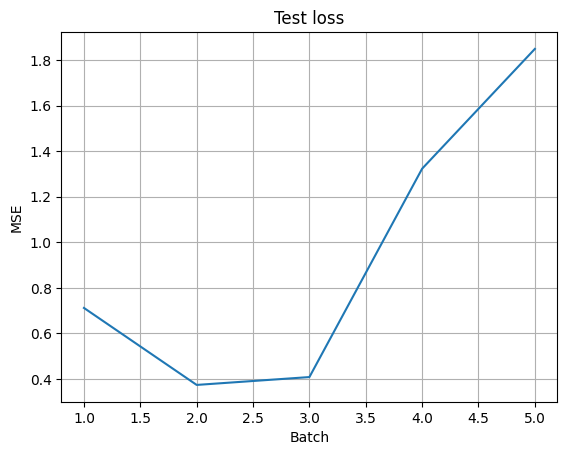

Avg test loss: 0.933157 

Epoch 14
-------------------------------
loss: 0.311782  [1/5]
loss: 1.835472  [2/5]
loss: 0.518962  [3/5]
loss: 0.412771  [4/5]
loss: 1.347112  [5/5]


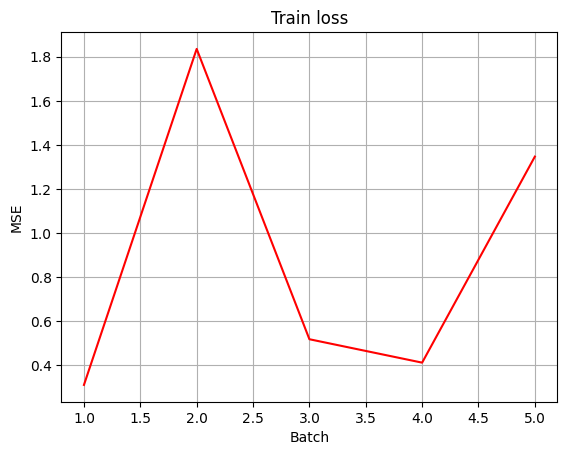

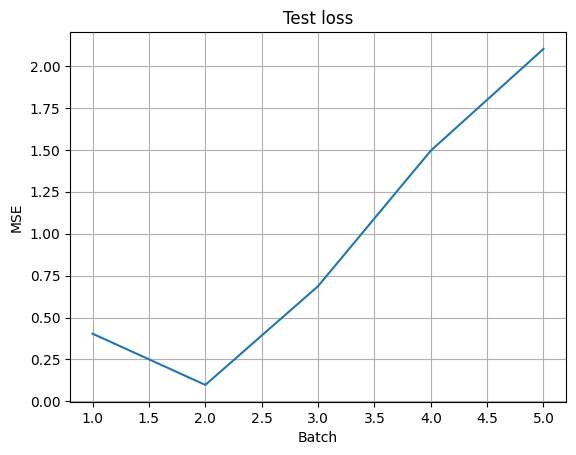

Avg test loss: 0.957021 

Epoch 15
-------------------------------
loss: 0.782872  [1/5]
loss: 1.191703  [2/5]
loss: 0.165286  [3/5]
loss: 1.770901  [4/5]
loss: 0.905774  [5/5]


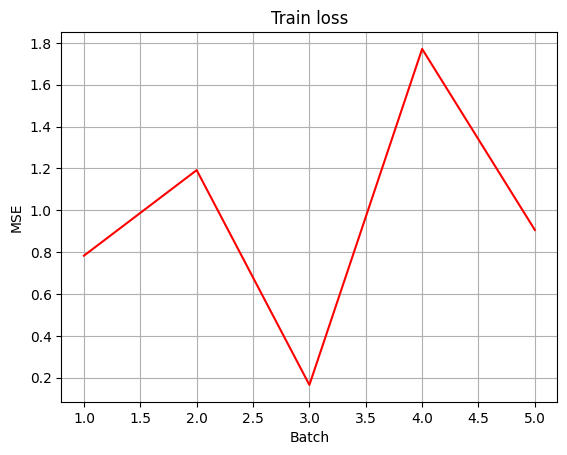

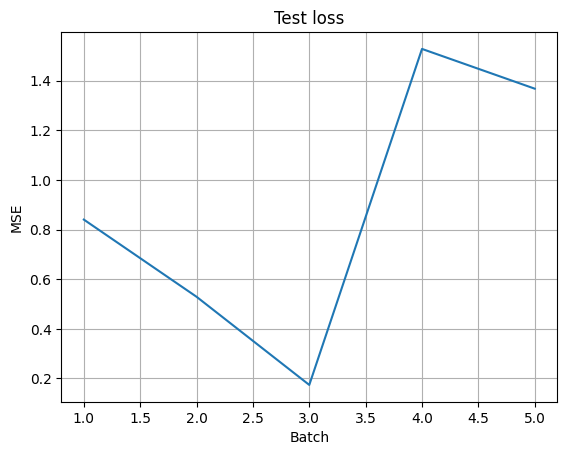

Avg test loss: 0.887932 

Done!


In [11]:
from networks import AlexNet


alexnet = AlexNet().to(device)
optimizer = torch.optim.Adam(alexnet.parameters(), lr=lr)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(dataloader, alexnet, loss, optimizer)
    test_loop(dataloader, alexnet, loss)
print("Done!")

## ResNet34

Epoch 1
-------------------------------
loss: 0.284982  [1/5]
loss: 8.601811  [2/5]
loss: 8.617939  [3/5]
loss: 0.922572  [4/5]
loss: 0.819112  [5/5]


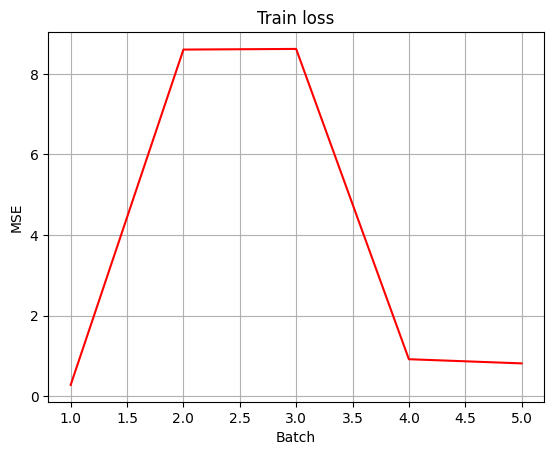

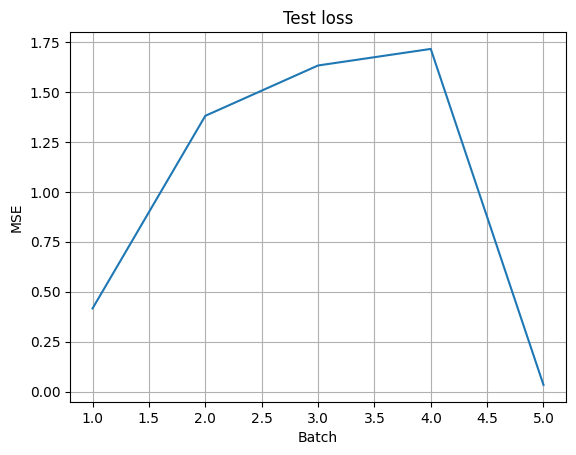

Avg test loss: 1.035429 

Epoch 2
-------------------------------
loss: 0.717863  [1/5]
loss: 1.326144  [2/5]
loss: 1.020527  [3/5]
loss: 0.275698  [4/5]
loss: 1.542229  [5/5]


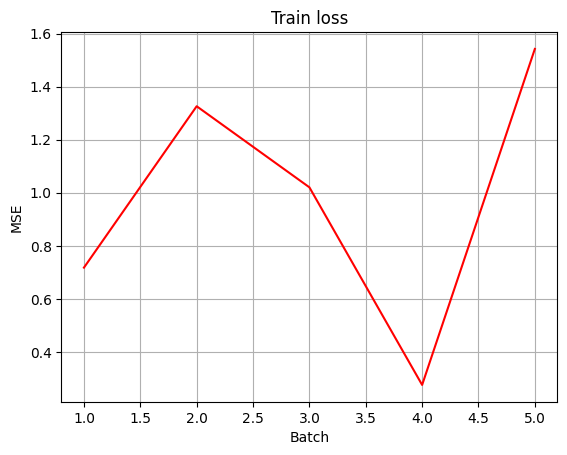

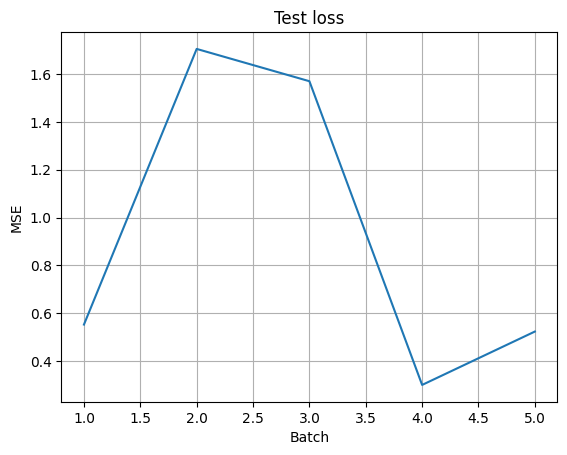

Avg test loss: 0.930380 

Epoch 3
-------------------------------
loss: 0.247175  [1/5]
loss: 1.554083  [2/5]
loss: 1.497885  [3/5]
loss: 0.336386  [4/5]
loss: 1.183109  [5/5]


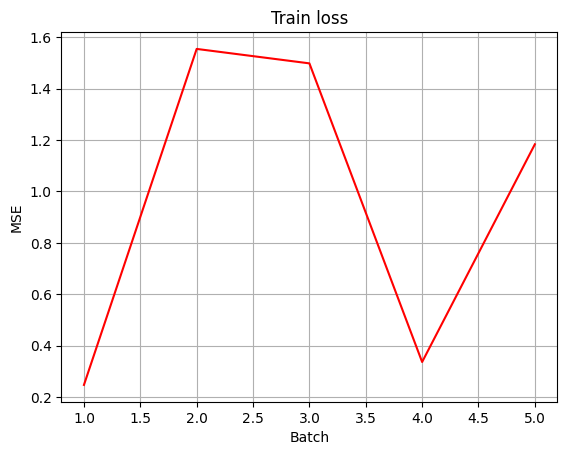

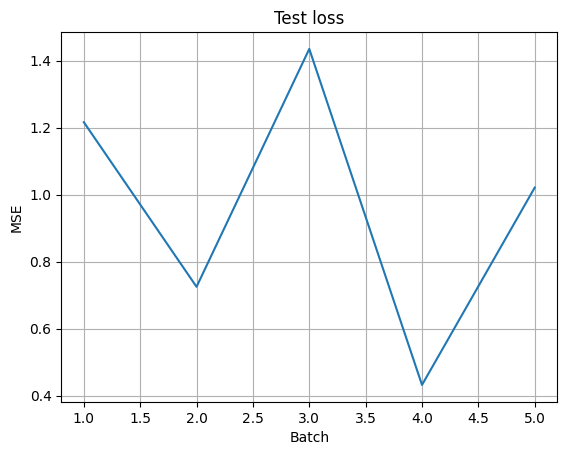

Avg test loss: 0.965733 

Epoch 4
-------------------------------
loss: 0.315444  [1/5]
loss: 1.684312  [2/5]
loss: 0.770677  [3/5]
loss: 1.116920  [4/5]
loss: 0.839393  [5/5]


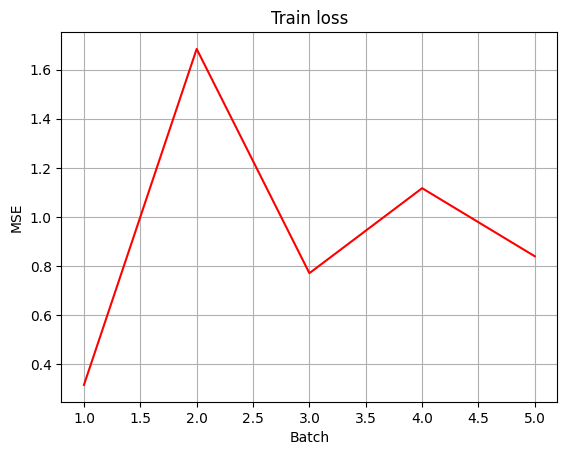

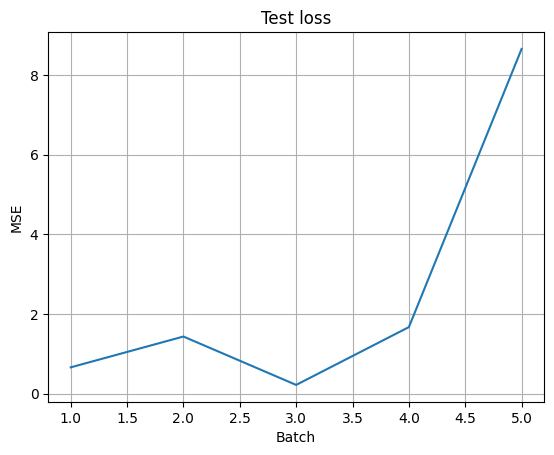

Avg test loss: 2.526677 

Epoch 5
-------------------------------
loss: 1.517781  [1/5]
loss: 1.359260  [2/5]
loss: 0.736357  [3/5]
loss: 0.330703  [4/5]
loss: 0.795096  [5/5]


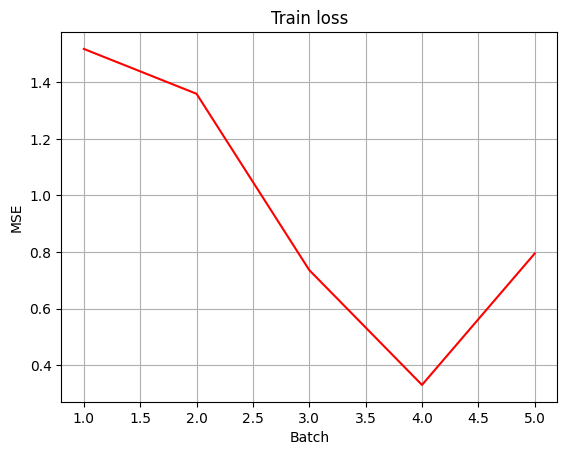

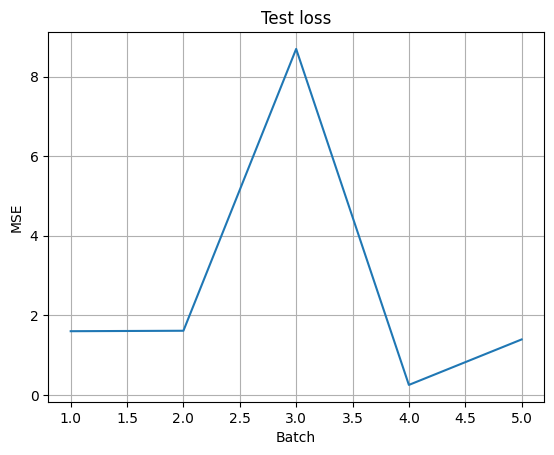

Avg test loss: 2.711388 

Epoch 6
-------------------------------
loss: 0.778904  [1/5]
loss: 1.720028  [2/5]
loss: 1.319889  [3/5]
loss: 0.581834  [4/5]
loss: 0.357444  [5/5]


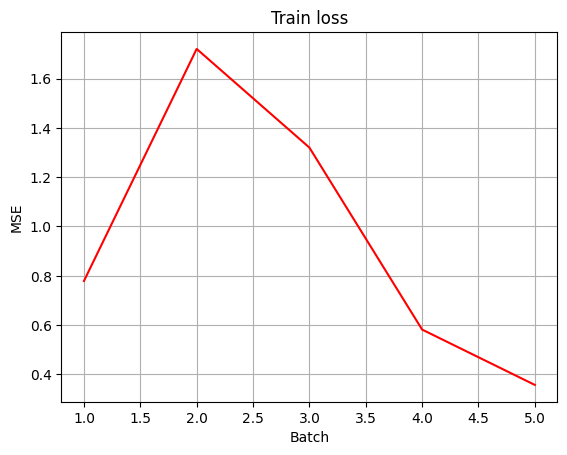

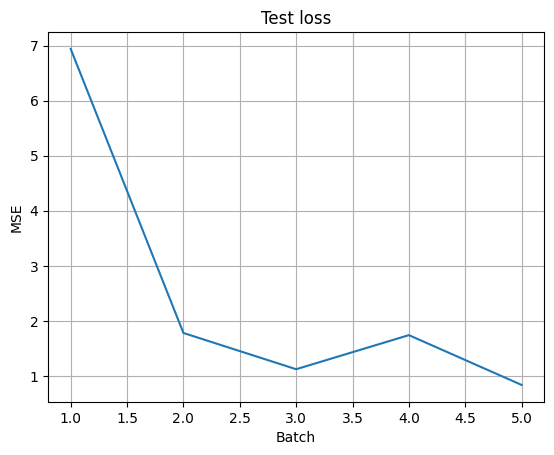

Avg test loss: 2.484573 

Epoch 7
-------------------------------
loss: 0.959869  [1/5]
loss: 1.572570  [2/5]
loss: 1.251284  [3/5]
loss: 0.365899  [4/5]
loss: 0.536101  [5/5]


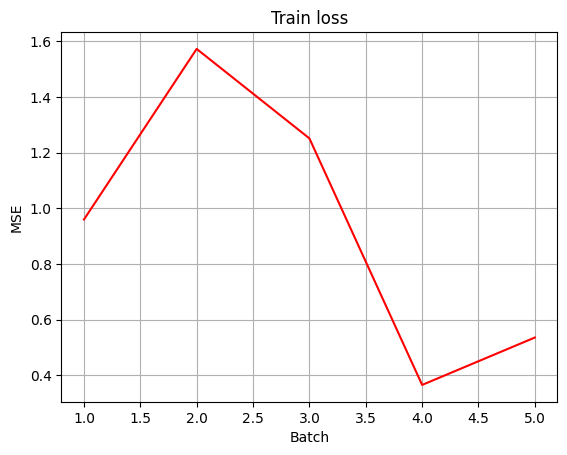

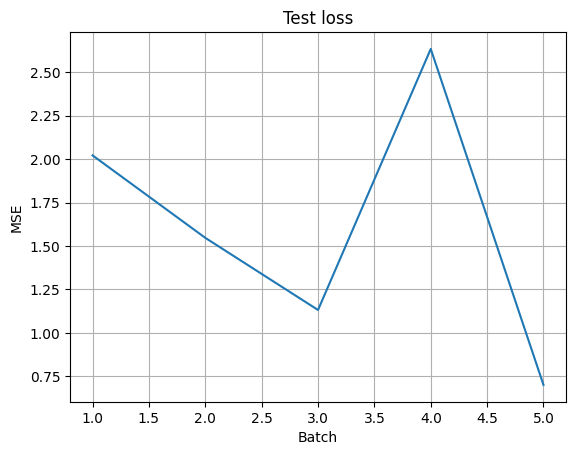

Avg test loss: 1.606990 

Epoch 8
-------------------------------
loss: 0.726710  [1/5]
loss: 1.061896  [2/5]
loss: 0.709207  [3/5]
loss: 1.305420  [4/5]
loss: 0.931538  [5/5]


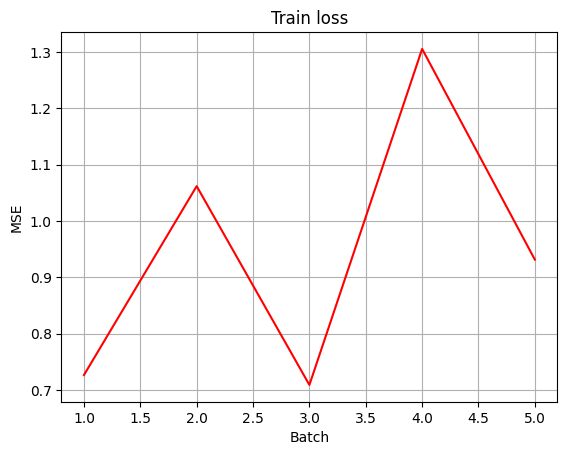

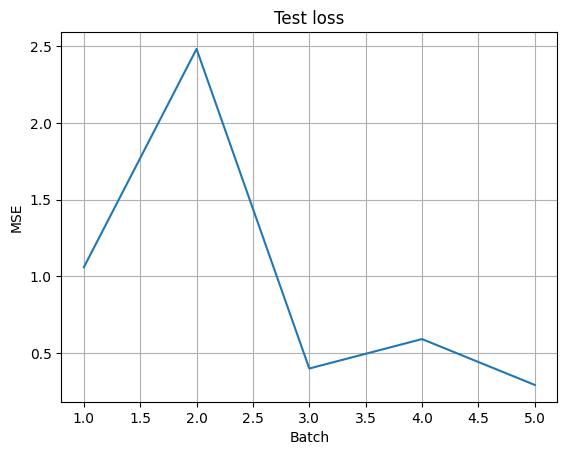

Avg test loss: 0.965489 

Epoch 9
-------------------------------
loss: 0.159833  [1/5]
loss: 2.422306  [2/5]
loss: 0.154822  [3/5]
loss: 1.424440  [4/5]
loss: 0.373236  [5/5]


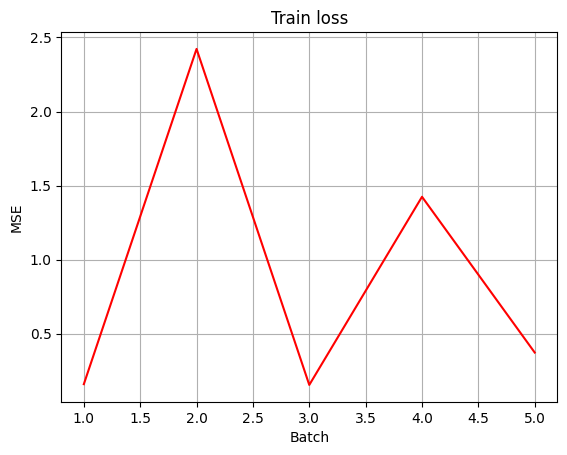

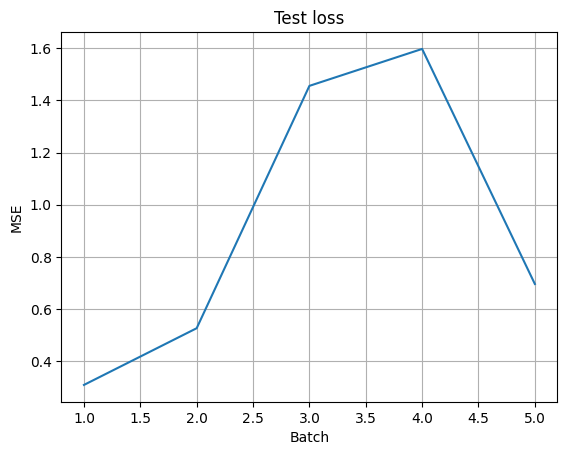

Avg test loss: 0.916879 

Epoch 10
-------------------------------
loss: 1.682501  [1/5]
loss: 0.368178  [2/5]
loss: 0.512713  [3/5]
loss: 1.867703  [4/5]
loss: 0.175911  [5/5]


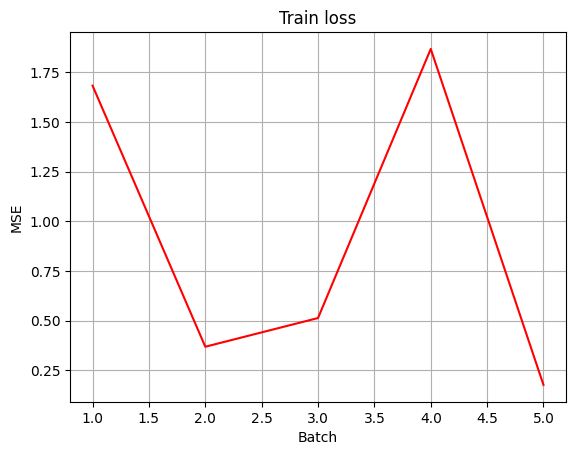

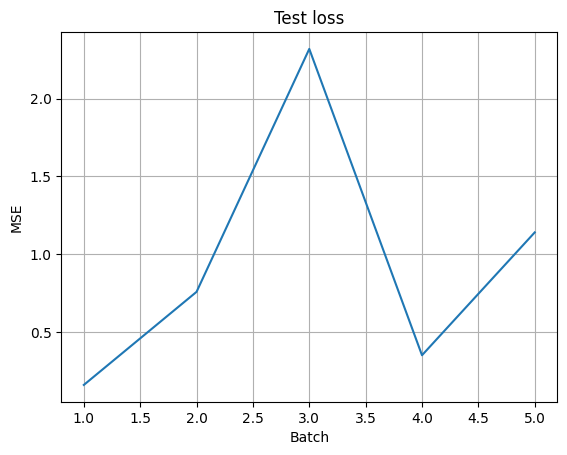

Avg test loss: 0.946689 

Epoch 11
-------------------------------
loss: 0.485938  [1/5]
loss: 1.613850  [2/5]
loss: 0.639605  [3/5]
loss: 0.199862  [4/5]
loss: 1.641381  [5/5]


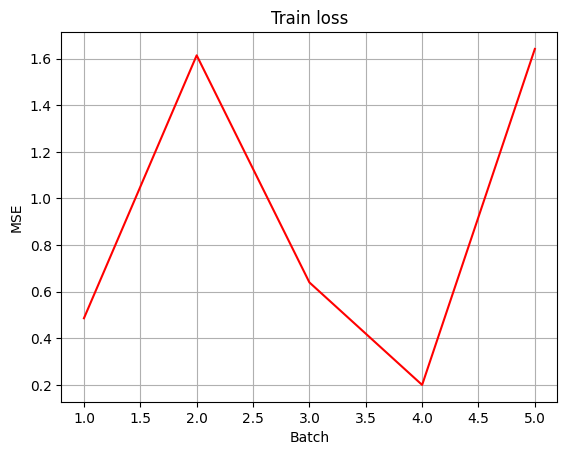

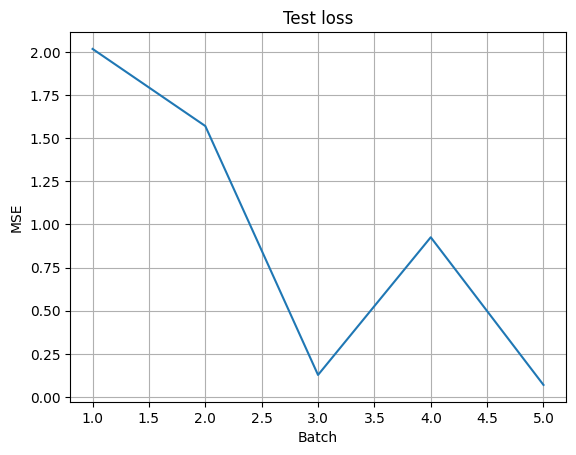

Avg test loss: 0.941807 

Epoch 12
-------------------------------
loss: 0.306057  [1/5]
loss: 1.828837  [2/5]
loss: 0.183279  [3/5]
loss: 2.238338  [4/5]
loss: 0.252684  [5/5]


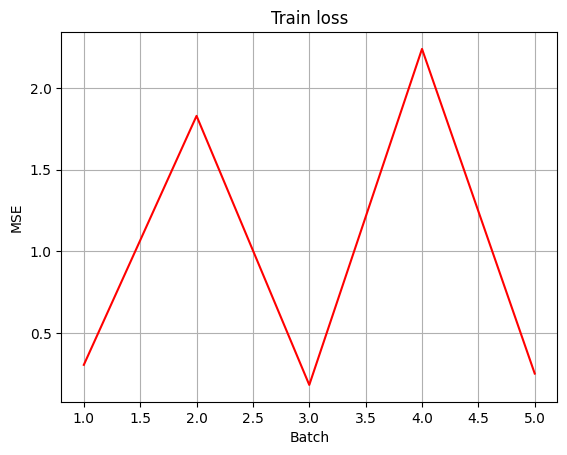

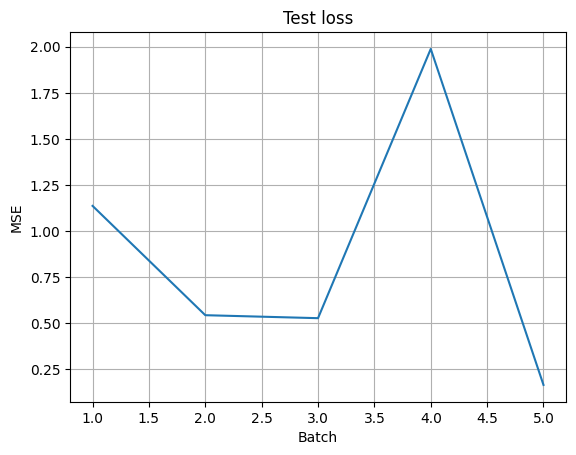

Avg test loss: 0.871059 

Epoch 13
-------------------------------
loss: 0.477000  [1/5]
loss: 1.962212  [2/5]
loss: 1.366501  [3/5]
loss: 0.727097  [4/5]
loss: 0.334755  [5/5]


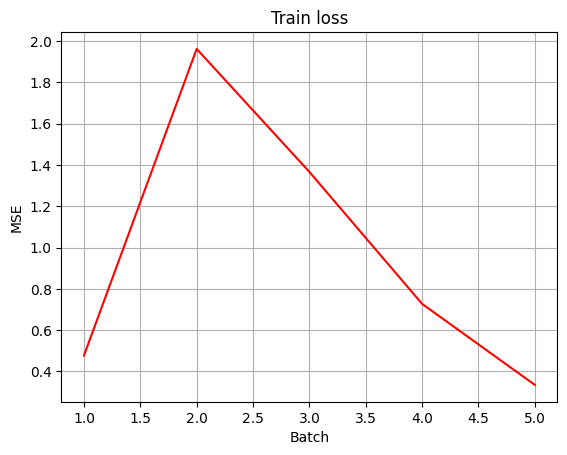

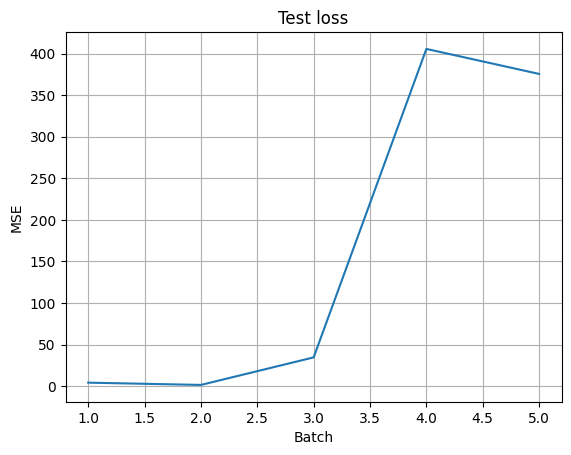

Avg test loss: 164.255168 

Epoch 14
-------------------------------
loss: 1.335995  [1/5]
loss: 1.271423  [2/5]
loss: 0.477474  [3/5]
loss: 0.753270  [4/5]
loss: 0.857193  [5/5]


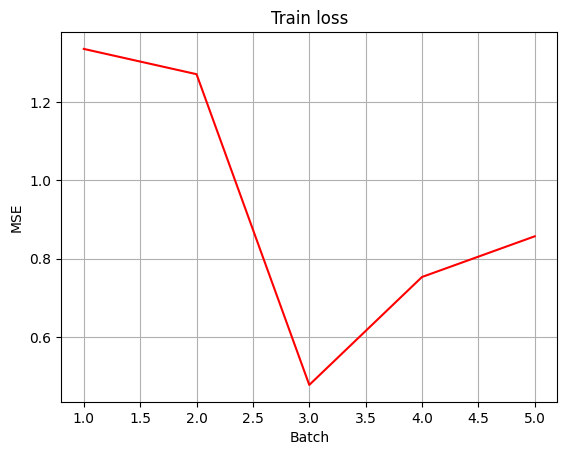

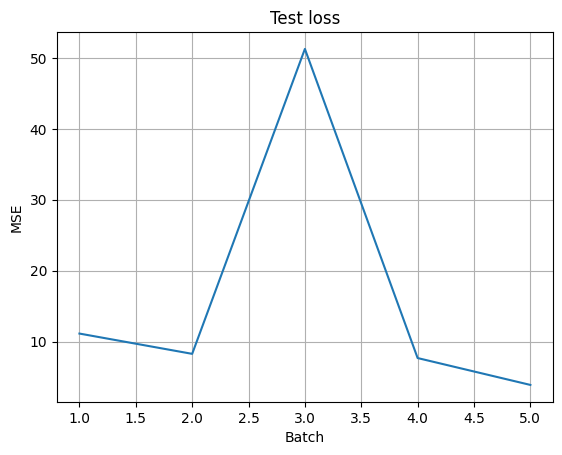

Avg test loss: 16.441133 

Epoch 15
-------------------------------
loss: 1.037470  [1/5]
loss: 0.595481  [2/5]
loss: 0.797725  [3/5]
loss: 1.343103  [4/5]
loss: 0.934531  [5/5]


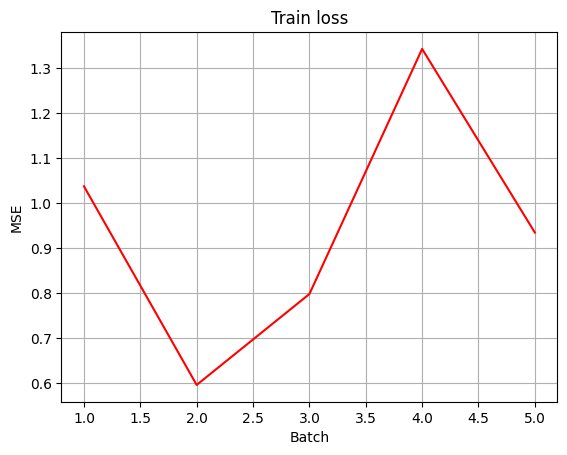

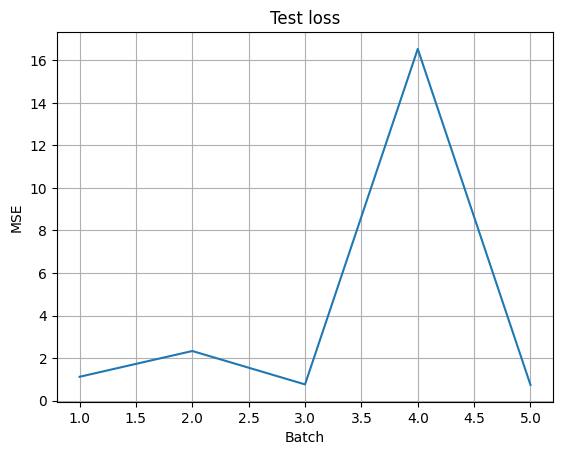

Avg test loss: 4.298154 

Done!


In [12]:
from networks import ResNet34


resnet34 = ResNet34().to(device)
optimizer = torch.optim.Adam(resnet34.parameters(), lr=lr)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(dataloader, resnet34, loss, optimizer)
    test_loop(dataloader, resnet34, loss)
print("Done!")

## ResNet18

Epoch 1
-------------------------------
loss: 1.527067  [1/5]
loss: 4.762971  [2/5]
loss: 5.425334  [3/5]
loss: 2.441233  [4/5]
loss: 0.687830  [5/5]


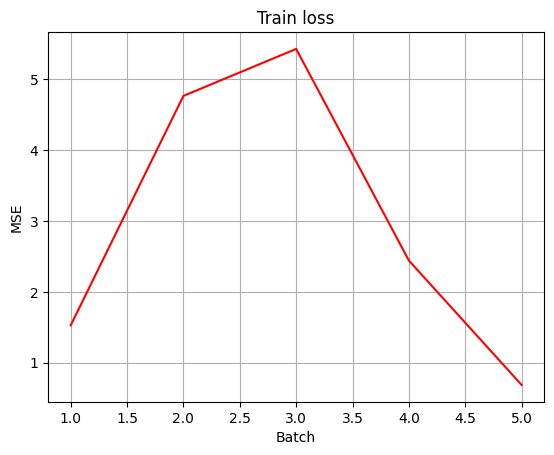

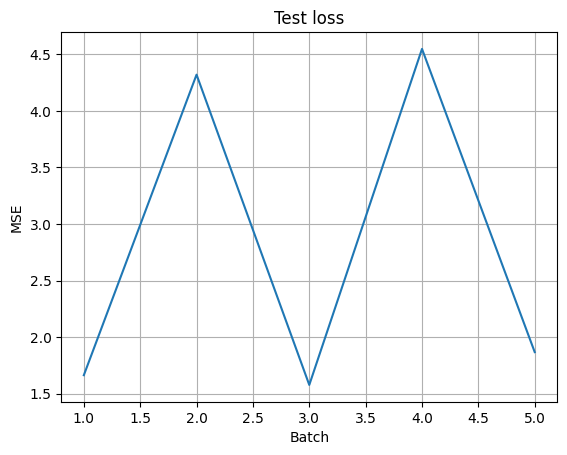

Avg test loss: 2.795413 

Epoch 2
-------------------------------
loss: 0.641771  [1/5]
loss: 1.183239  [2/5]
loss: 1.600856  [3/5]
loss: 0.099078  [4/5]
loss: 2.021787  [5/5]


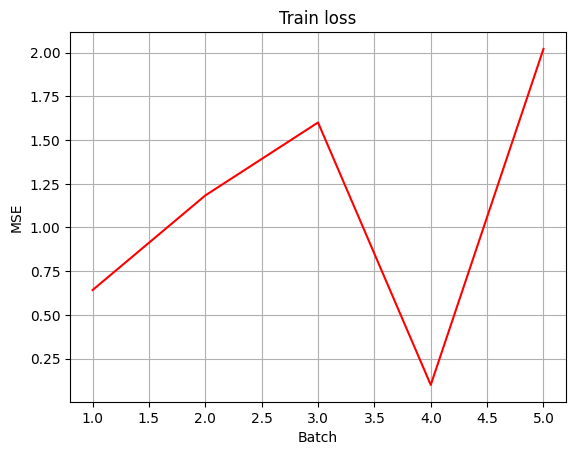

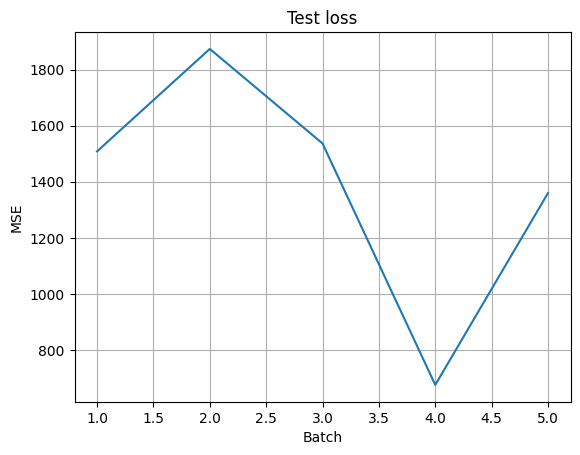

Avg test loss: 1390.767236 

Epoch 3
-------------------------------
loss: 0.596008  [1/5]
loss: 0.704740  [2/5]
loss: 1.414710  [3/5]
loss: 0.904220  [4/5]
loss: 1.577143  [5/5]


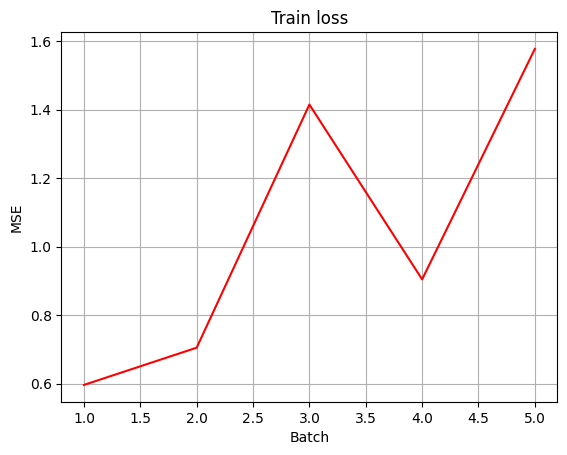

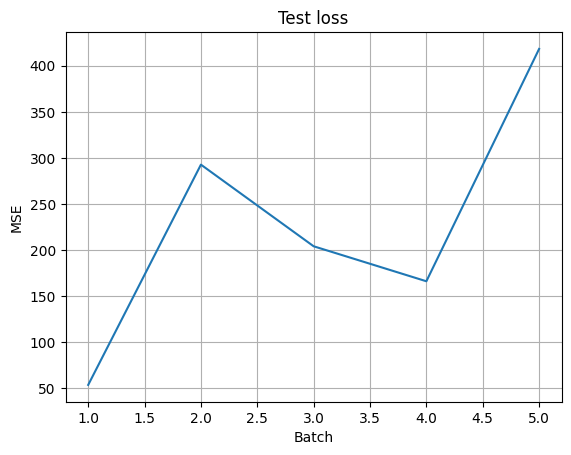

Avg test loss: 226.973065 

Epoch 4
-------------------------------
loss: 0.214113  [1/5]
loss: 1.150764  [2/5]
loss: 0.956626  [3/5]
loss: 2.110094  [4/5]
loss: 0.623664  [5/5]


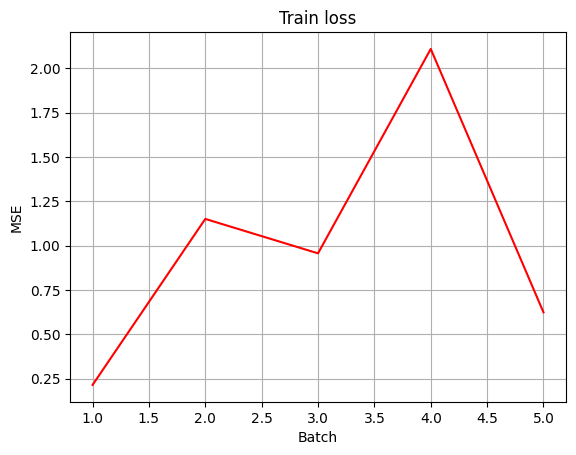

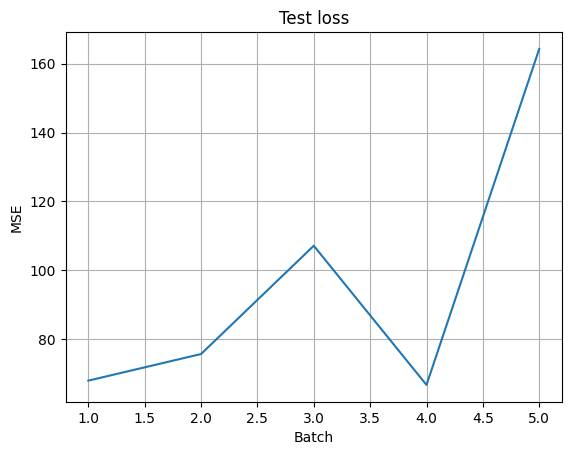

Avg test loss: 96.343488 

Epoch 5
-------------------------------
loss: 1.366337  [1/5]
loss: 1.537768  [2/5]
loss: 0.424089  [3/5]
loss: 0.600317  [4/5]
loss: 0.971809  [5/5]


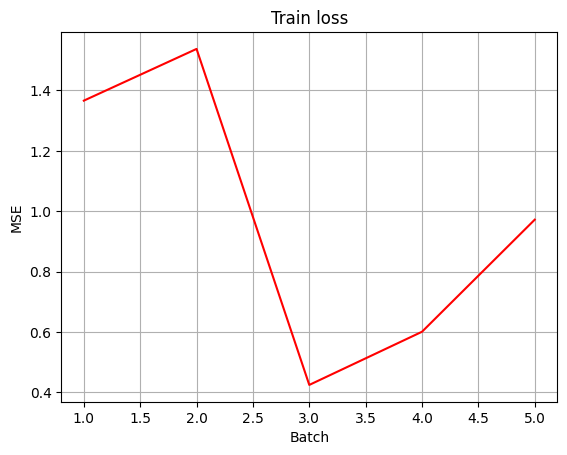

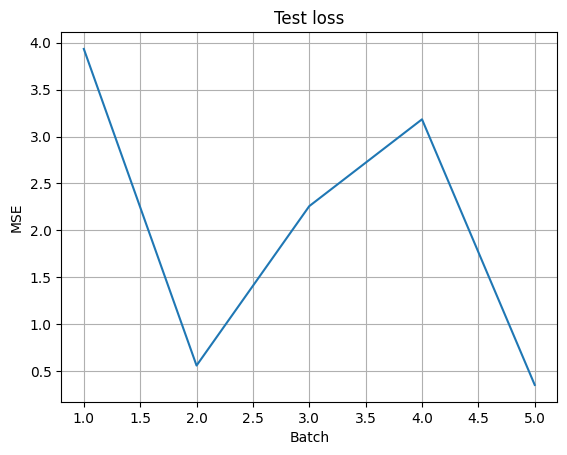

Avg test loss: 2.058804 

Epoch 6
-------------------------------
loss: 0.474725  [1/5]
loss: 0.331180  [2/5]
loss: 1.845644  [3/5]
loss: 0.377246  [4/5]
loss: 1.745535  [5/5]


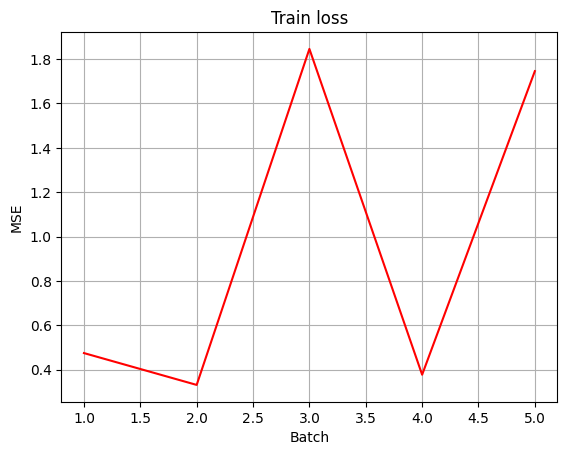

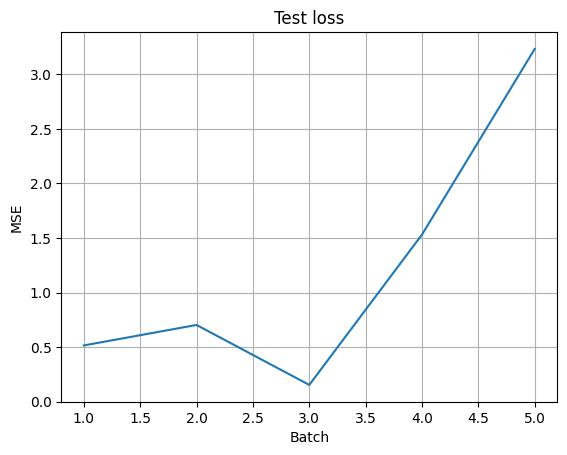

Avg test loss: 1.226986 

Epoch 7
-------------------------------
loss: 0.705795  [1/5]
loss: 1.241534  [2/5]
loss: 1.474185  [3/5]
loss: 0.123469  [4/5]
loss: 1.286323  [5/5]


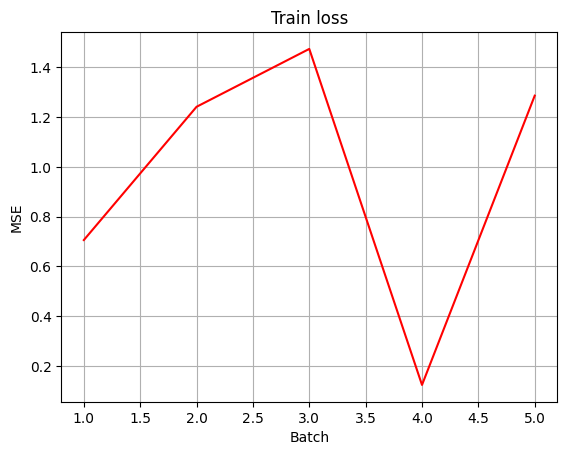

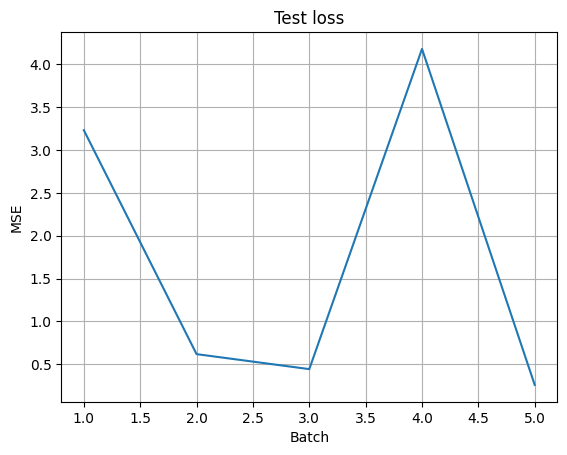

Avg test loss: 1.746480 

Epoch 8
-------------------------------
loss: 1.189578  [1/5]
loss: 0.463654  [2/5]
loss: 0.915120  [3/5]
loss: 0.733064  [4/5]
loss: 1.426554  [5/5]


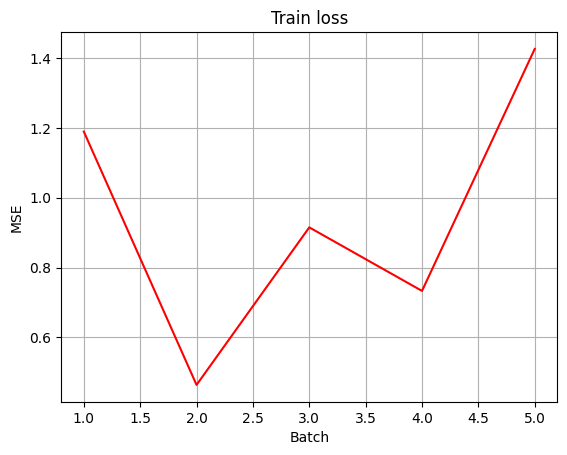

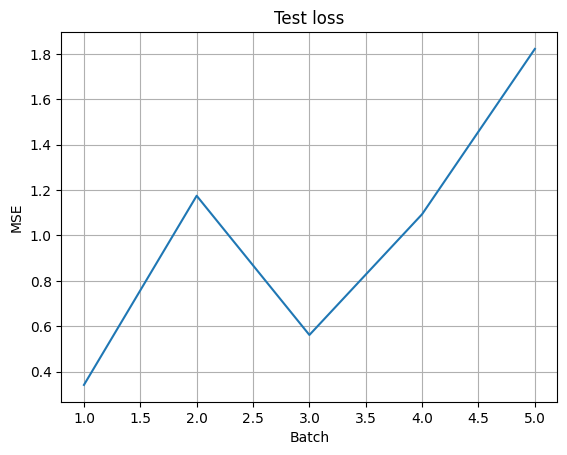

Avg test loss: 0.998628 

Epoch 9
-------------------------------
loss: 1.780538  [1/5]
loss: 0.320824  [2/5]
loss: 0.755077  [3/5]
loss: 0.599264  [4/5]
loss: 1.441853  [5/5]


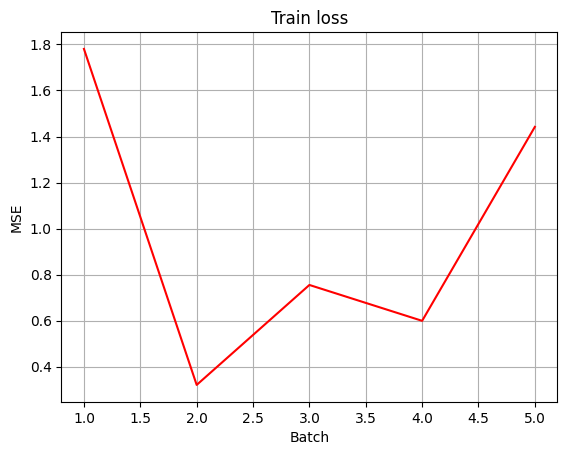

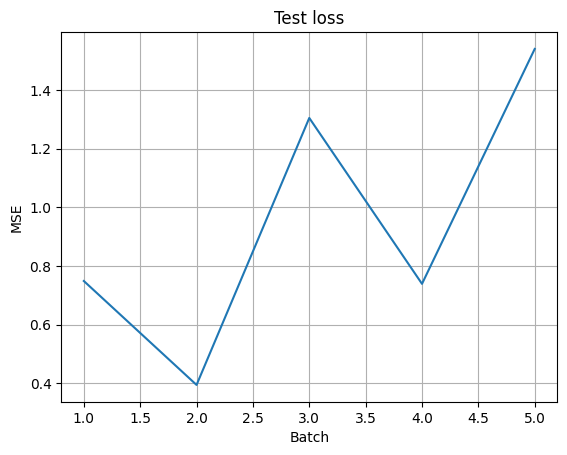

Avg test loss: 0.945043 

Epoch 10
-------------------------------
loss: 0.830441  [1/5]
loss: 0.148904  [2/5]
loss: 1.538646  [3/5]
loss: 1.469843  [4/5]
loss: 0.864726  [5/5]


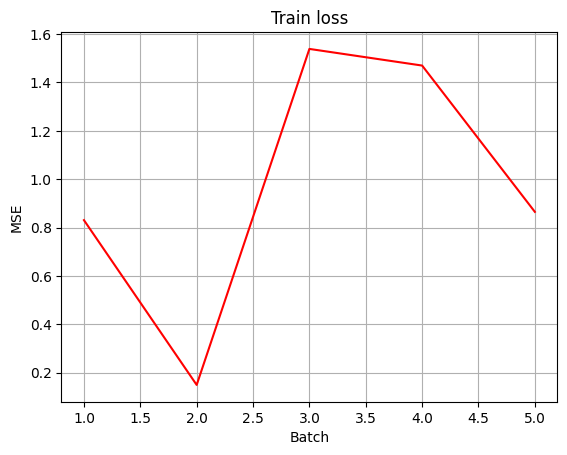

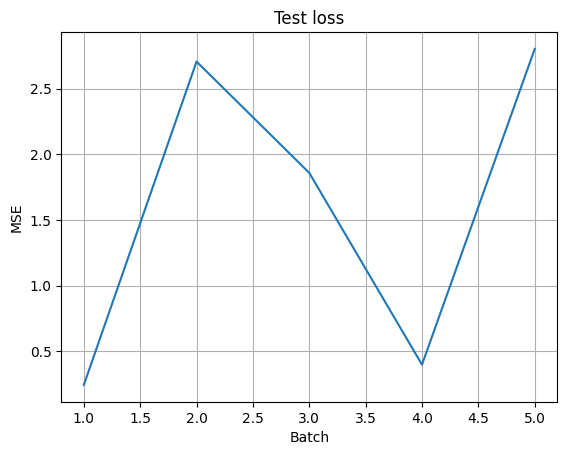

Avg test loss: 1.601904 

Epoch 11
-------------------------------
loss: 1.123856  [1/5]
loss: 0.236445  [2/5]
loss: 1.801216  [3/5]
loss: 0.383958  [4/5]
loss: 1.169461  [5/5]


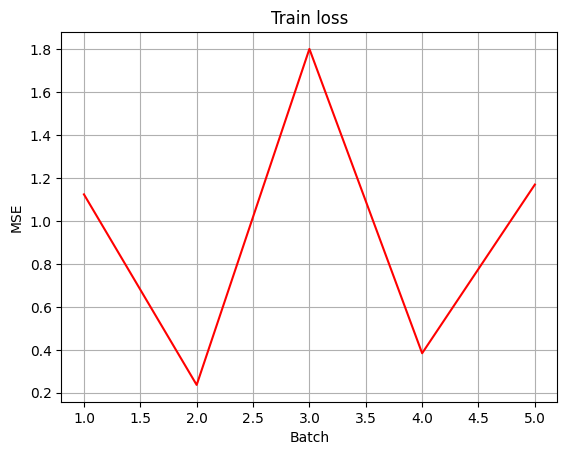

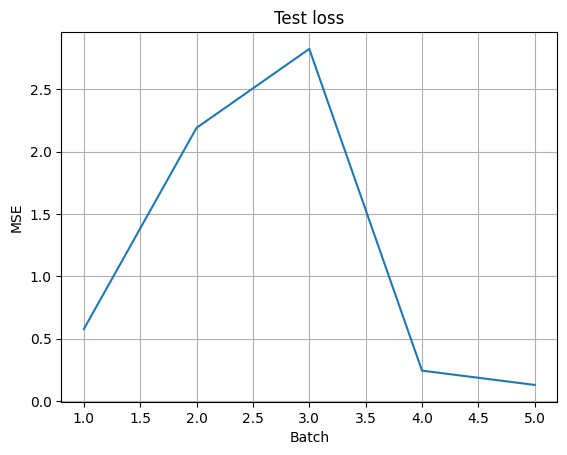

Avg test loss: 1.192976 

Epoch 12
-------------------------------
loss: 0.229970  [1/5]
loss: 0.942189  [2/5]
loss: 2.575552  [3/5]
loss: 0.317565  [4/5]
loss: 0.561594  [5/5]


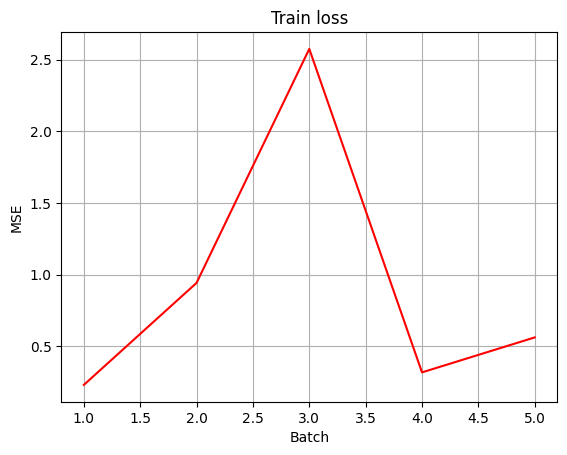

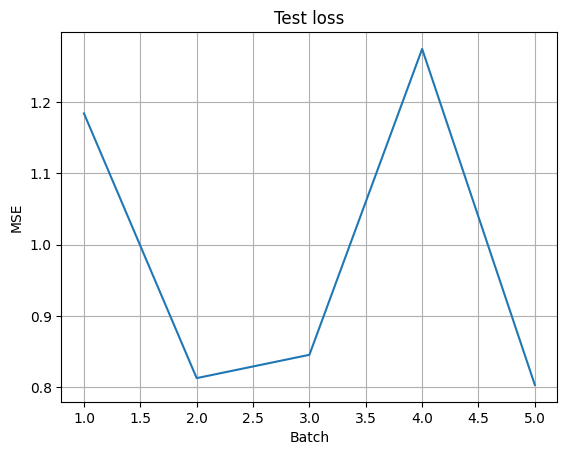

Avg test loss: 0.983937 

Epoch 13
-------------------------------
loss: 0.208624  [1/5]
loss: 1.108048  [2/5]
loss: 0.406667  [3/5]
loss: 0.832563  [4/5]
loss: 2.069505  [5/5]


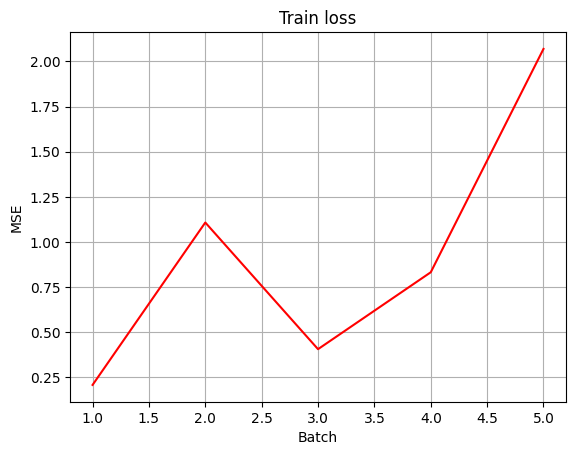

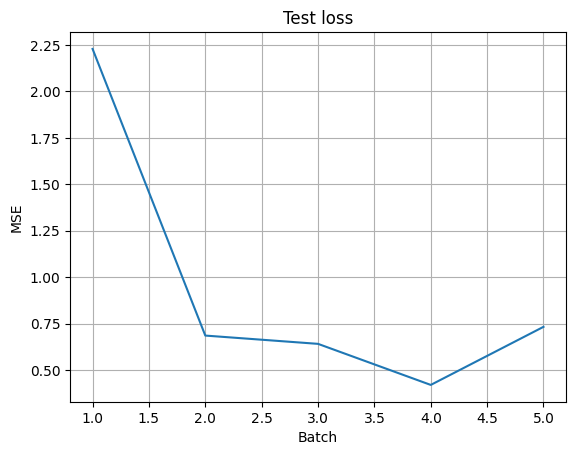

Avg test loss: 0.941391 

Epoch 14
-------------------------------
loss: 0.633237  [1/5]
loss: 0.589171  [2/5]
loss: 0.135383  [3/5]
loss: 2.780654  [4/5]
loss: 0.472565  [5/5]


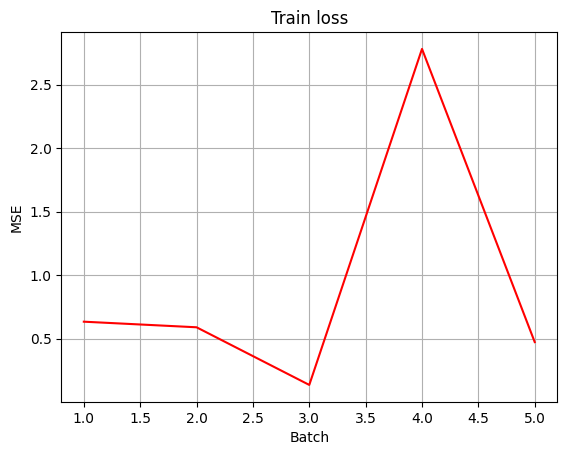

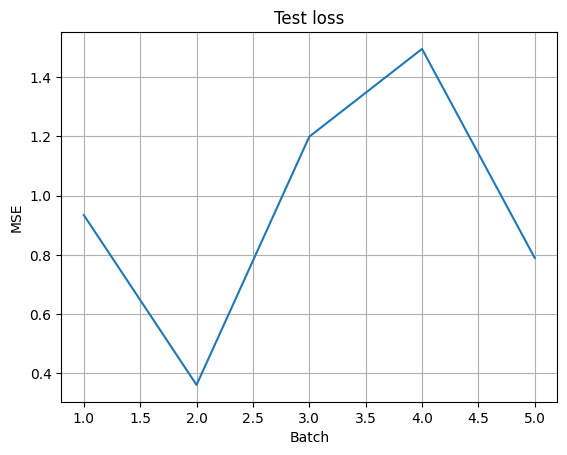

Avg test loss: 0.955987 

Epoch 15
-------------------------------
loss: 1.153721  [1/5]
loss: 1.865880  [2/5]
loss: 0.252118  [3/5]
loss: 0.957090  [4/5]
loss: 0.522736  [5/5]


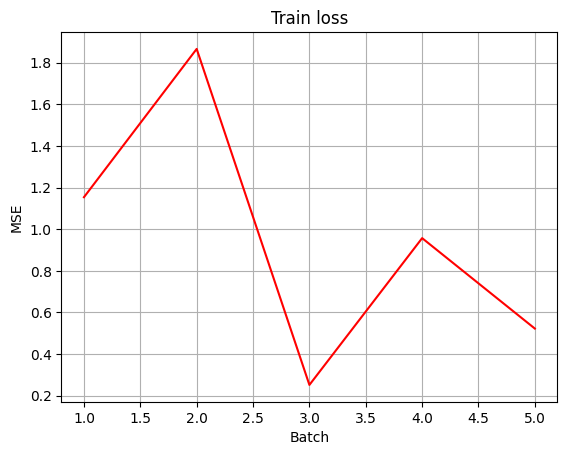

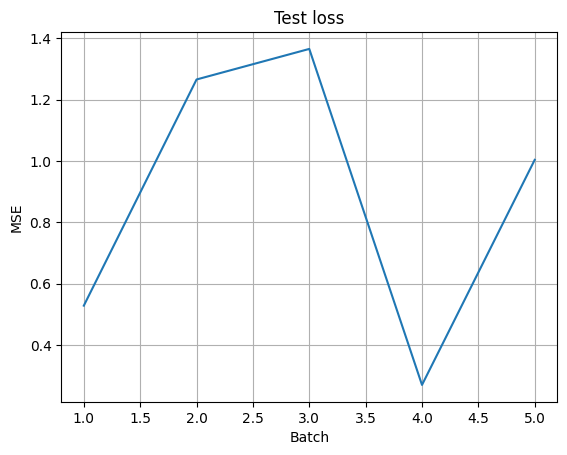

Avg test loss: 0.886494 

Done!


In [13]:
from networks import ResNet18


resnet18 = ResNet18().to(device)
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}\n-------------------------------")
    train_loop(dataloader, resnet18, loss, optimizer)
    test_loop(dataloader, resnet18, loss)
print("Done!")